Imports for the algorithm

In [263]:
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import copy
from itertools import product
from functools import reduce

Load file from local memory.

In [159]:
filename = "IMOS_SOOP-BA_AE_20160412T031347Z_VLMJ_FV02_Investigator-EK60-18_END-20160414T043251Z_C-20210622T061448Z.nc"
ds = xr.open_dataset(filename)

Plot the sv data

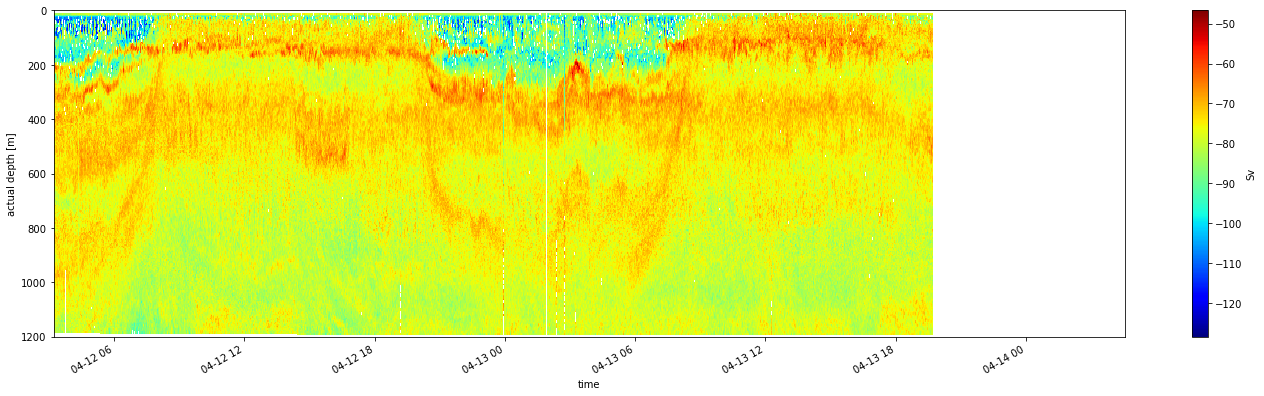

In [9]:
# plot sv data with 10log_10 scaling
fig = (10*np.log10(ds.Sv)).plot(x='TIME', size=6, aspect=4, cmap="jet")
# invert y axis so that depth increases downwards
plt.gca().invert_yaxis()

Initiate a rolling object for ds.Sv, with a window size and a minimum number of values to begin computing
(i.e. skip the edges until at least that many values are in the window. Proud calls for 3)

In [39]:
# rolling object
depthRoll = ds.Sv.rolling(DEPTH=10, min_periods=3)

Implement np.nanmean over the dataset using the rolling object

<em>see documentation for [DataArrayRolling.reduce()](https://xarray.pydata.org/en/stable/generated/xarray.core.rolling.DataArrayRolling.reduce.html#xarray.core.rolling.DataArrayRolling.reduce)</em>

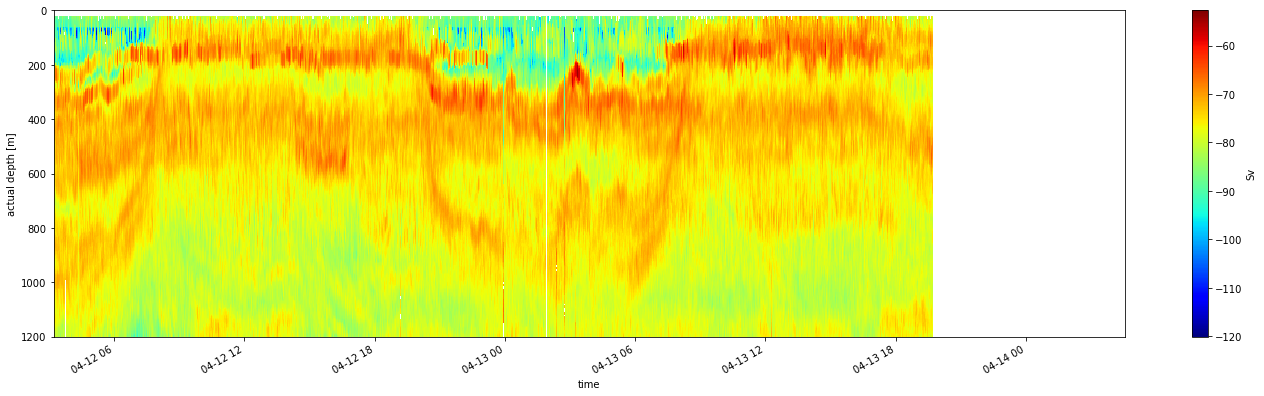

In [41]:
# execute nanmean function over the window 
rollednanMean = depthRoll.reduce(np.nanmean)

# plot data with 10log_10 scaling
fig = (10*np.log10(rollednanMean)).plot(x='TIME', size=6, aspect=4, cmap="jet")
# invert y axis so that depth increases downwards
plt.gca().invert_yaxis()

Basic structure behind algorithm:

1) $a$ is an example vector, ie a column of Sv data

In [136]:
a = xr.DataArray(np.arange(10), dims=("dim1"))
a

<xarray.DataArray (dim1: 10)>
array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
Dimensions without coordinates: dim1

2) next we flip $a$ to get a vector of the same data, but in opposite order: $b$

In [151]:
b = xr.DataArray(np.flip(a.data),  dims=("dim1"))
b

<xarray.DataArray (dim1: 10)>
array([9, 8, 7, 6, 5, 4, 3, 2, 1, 0])
Dimensions without coordinates: dim1

3) xarray's .rolling() method allows us to move a left-hand side window across the data vectors $a$ and $b$, and we construct an additional dimension using a window of size <em>window_size</em>


In [143]:
window_size = len(a)
rolling_above = a.rolling(dim1=window_size) 
window_above = rolling_above.construct("window_dim").data
window_above

array([[nan, nan, nan, nan, nan, nan, nan, nan, nan,  0.],
       [nan, nan, nan, nan, nan, nan, nan, nan,  0.,  1.],
       [nan, nan, nan, nan, nan, nan, nan,  0.,  1.,  2.],
       [nan, nan, nan, nan, nan, nan,  0.,  1.,  2.,  3.],
       [nan, nan, nan, nan, nan,  0.,  1.,  2.,  3.,  4.],
       [nan, nan, nan, nan,  0.,  1.,  2.,  3.,  4.,  5.],
       [nan, nan, nan,  0.,  1.,  2.,  3.,  4.,  5.,  6.],
       [nan, nan,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.],
       [nan,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.],
       [ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9.]])

In [111]:
rolling_below = b.rolling(dim1=10,min_periods=7)
window_below = rolling_below.construct("window_dim").data
window_below

array([[nan, nan, nan, nan, nan, nan, nan, nan, nan,  9.],
       [nan, nan, nan, nan, nan, nan, nan, nan,  9.,  8.],
       [nan, nan, nan, nan, nan, nan, nan,  9.,  8.,  7.],
       [nan, nan, nan, nan, nan, nan,  9.,  8.,  7.,  6.],
       [nan, nan, nan, nan, nan,  9.,  8.,  7.,  6.,  5.],
       [nan, nan, nan, nan,  9.,  8.,  7.,  6.,  5.,  4.],
       [nan, nan, nan,  9.,  8.,  7.,  6.,  5.,  4.,  3.],
       [nan, nan,  9.,  8.,  7.,  6.,  5.,  4.,  3.,  2.],
       [nan,  9.,  8.,  7.,  6.,  5.,  4.,  3.,  2.,  1.],
       [ 9.,  8.,  7.,  6.,  5.,  4.,  3.,  2.,  1.,  0.]])

4. In this implementation, we treat the right hand column of these above matrices as the index. In other words, the elements to the left of the right hand column are all of the elements indexed above/below the indexed element, respectively. 

    The first rows are the elements above the first element and below the last element, which we replace with NaN. The rest, we use nanmean() to collapse the window dimension in to the means below/above the index of that row, respectively, and so we do not include the right hand column.

In [144]:
np.concatenate(([np.nan], np.nanmean(window_above[1:, :-1],1)))

array([nan, 0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. ])

In [145]:
np.concatenate(([np.nan], np.nanmean(window_below[1:, :-1],1)))

array([nan, 9. , 8.5, 8. , 7.5, 7. , 6.5, 6. , 5.5, 5. ])

5. These arrays above are the means within the window size above and below each element in the data vector. Note that the window size INCLUDES the element in question in this implementation. As a result, if we want our smallest mean to still have 2 values, our smallest window size is 3.

    Finally, these windowed means get compared to $a$, and we return true if $a$ is greater than both of them.
    
    We would then run this process for all relavant window sizes.

# Proud, 2015 algorithm implementation

This method is a first pass at implementing just the windowed comparison and masking portion of the Proud algorithm.

In [148]:
def run_window(xarr_col, above_window_size, below_window_size):
    '''
    find_layer: defines a boolean mask for one column of xarray data determining if each pixel 
                is an SSL as described in Proud 2015. 
                Rolls window of length "above_window_size" forward from the start of the array, 
                and window of length "below_window_size" backwards from the end of the array 
                (executed by flipping xarr_col). An auxillary "window" dimension is created using 
                rolling.construct() with all values above/below each element of xarr_col 
                within the defined above/below window sizes.
                The mean of the above and below windows are taken along this dimension,
                excluding the element shared by both windows. This element's values is compared
                to these window means: the mask returns TRUE if the element's value is greater
                than both means and FALSE otherwise.
    Inputs: xarr_col (xarray.DataArray, 1 dimension) - one column of data (i.e. one ping)
            above_window_size (int) - number of elements above and including each pixel to enter
                                        expand into the window dimension
            below_window_size (int) - number of elements below and including each pixel to enter
                                        expand into the window dimension 
    Outputs: col_mask (array of boolean) - logical array of length len(xarr_col), which is TRUE only
                                        for corresponding elements of input data which have been 
                                        identified as an SSL within these window sizes
    '''
    def window_mean(xarr_col,window_size,min_per):
        '''
        window_mean: expands xarr_col vector into auxillary "window" dimension of size window_size
                   and take nanmean within the window
                   expands xarr_col vector into 
        '''
        window_matrix = xarr_col.rolling({xarr_col.dims[0]:window_size},min_periods=min_per).construct("window_dim")
        # take the mean of each row in the window dimension, excluding pixel at index of rolling window and 
        # excludes first row with no above elements
        return np.concatenate(([np.nan], np.nanmean(window_matrix[1:, :-1],1)))
    
    above_mean = window_mean(xarr_col,above_window_size,above_window_size) # means for above windows
    flipped_xarr_col = xr.DataArray(np.flip(xarr_col.data), dims=(xarr_col.dims[0]))
    below_mean = window_mean(flipped_xarr_col,below_window_size,below_window_size) # means for below windows
    
    col_mask = (above_mean < xarr_col.data) & (np.flip(below_mean) < xarr_col.data) # create mask by comparing window means
    return col_mask

In [156]:

def find_layers(xarr_col):
    # possible window sizes (3 is min due to including rolling pixel and Proud wanting window to be at least size 2)
    window_sizes = range(3, len(xarr_col.data)) 
    # all possible combinations of window sizes
    size_list = list(filter(lambda x: (x[0] + x[1]) < len(xarr_col) + 1, list(product(window_sizes, repeat = 2))))
    #size_list
    # combines all window masks into one masks
    flipped_xarr_col = xr.DataArray(np.flip(xarr_col.data), dims=(xarr_col.dims[0]))
    return reduce(lambda xarr_col, flipped_xarr_col: xarr_col|flipped_xarr_col, [find_layer(xarr_col, x[0], x[1]) for x in size_list])

# Illustrative test of algorithm

Grab first few columns of data

In [300]:
n = 5 # number of columns to test
test_columns = xr.DataArray(ds.Sv.isel(TIME=slice(0,n)),dims=("TIME","DEPTH"))

Run the columns through find_layers()

In [301]:
def sv_to_SSLmask(xarr):
    '''
    sv_to_SSLmask: 
    INPUT: 
        xarr (xarray) Sv data with TIME dimension
    '''
    masked_columns = copy.deepcopy(xarr)
    # loop over all columns
    for t in range(0,xarr.shape[1]-1):
        masked_columns.data[t] = find_layers(xarr.isel(TIME=t))
    return masked_columns

masked_columns = sv_to_SSLmask(test_columns)

/tmp/ipykernel_47/967450649.py:32: RuntimeWarning: Mean of empty slice
  return np.concatenate(([np.nan], np.nanmean(window_matrix[1:, :-1],1)))


IndexError: index 5 is out of bounds for axis 0 with size 5

Plot original data and data mask side by side:

/srv/conda/lib/python3.9/site-packages/xarray/core/computation.py:742: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


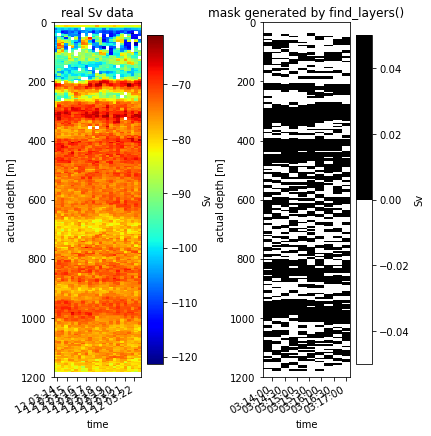

In [299]:
fig, axes = plt.subplots(1,2,figsize=(6,6))

# plot data with 10log_10 scaling
cmap = mpl.colors.ListedColormap(['w', 'k'])
fig = (10*np.log10(test_columns)).plot(x='TIME', cmap="jet",ax=axes[0])
fig = (10*np.log10(masked_columns)).plot(x='TIME', cmap=cmap,ax=axes[1])

plt.tight_layout()

# invert y axis so that depth increases downwards
axes[0].invert_yaxis()
axes[1].invert_yaxis()

# titles
axes[0].set_title("real Sv data");
axes[1].set_title("mask generated by find_layers()");
